# 1 -Perkenalan

Nama : St. Syakirah

Batch : FTDS-016-RMT

Problem : Brain Tumor Detection Using Convolutional Neural Network 

Dataset : Brain Tumor MRI Dataset (https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection)

Penyakit tumor otak adalah pertumbuhan sel otak yang abnormal di dalam atau di sekitarotak secara tidak wajar dan tidak terkendali. Kasus tumor otak di dunia semakin meningkat setiap tahunnya. Di Indonesia, terhitung ada 300 pasien setiap tahunnya yang terdiagnosis tumor otak. Pendekatan anatomi citra kesehatan menjadi salah satu cara yang dapat digunakan untuk mengetahui keberadaan tumor pada otak. Misalnya Magnetic Resonance Imaging (MRI). MRI bisa memberikan gambaran informasi yang jelas antara jaringan lunak dan jaringan keras yang terdapat pada otak. Hasil dari MRI dapat memberikan informasi penting bagi dokter untuk melakukan evaluasi dan diagnosis. 

Metode yang biasa digunakan oleh dokter dalam pengambilan keputusan terhadap tumor otak adalah biopsi dan pengamatan langsung dalam diagnosis secara manual. Biopsi memerlukan waktu yang tidak cepat sekitar 10 sampai 15 hari untuk pengujian laboratorium, sedangkan diagnosis secara manual memiliki resiko terjadinya kesalahan. Sehingga diperlukan metode alternatif yang cepat dan memiliki tingkat kesalahan yang rendah untuk dapat membantu dokter dalam mengambil keputusan.

Membangun model deep learning dapat membantu dokter dalam mengurangi tingkat kesalahan dalam diagnosis tumor otak. Berdasarkan dari uraian Latar Belakang
diatas, maka penelitian ini bertujuan untuk membuat ”Brain tumor classification Using Concolutional Neural Network".

Reference :
Rachmad A.R., Bagas W.P., Rani P., 2021, KLASIFIKASI TUMOR OTAK MENGGUNAKAN CONVOLUTIONAL NEURAL NETWORK DENGAN ARSITEKTUR EFFICIENTNET-B3, Jurnal Sistem Informasi, Teknologi Informasi dan Komputer, 11(3), pp.55-59.

Link jurnal:
https://jurnal.umj.ac.id/index.php/just-it/index


# 2 - Import Libraries

In [ ]:
import os
import glob
import numpy as np
import pandas as pd

# Visualisasi
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator #Augmentasi data
# Modeling
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense, Dropout, Flatten, Input, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from keras.optimizers import SGD
#Evaluation
from sklearn.metrics import confusion_matrix, classification_report
import itertools
# Load Model
from tensorflow.keras.models import load_model

import warnings
warnings.filterwarnings('ignore')

# 3 - Data Loading

In [ ]:
#Buat folder di kaggle root
!mkdir -p ~/.kaggle 
# copy paster kaggle.json ke folder kaggle 
!cp kaggle.json ~/.kaggle # copy paster kaggle.json ke folder kaggle 
# Buat folder kaggle di lokasi sama (bukan di root)
!mkdir ./kaggle 
# Pindahkan file kaggle.json ke folder kaggle
!mv ./kaggle.json ./kaggle

In [ ]:
# Perizinan akses
!chmod 600 ~/.kaggle/kaggle.json 
#cek list data yang ada di folder kaggle
!ls ~/.kaggle 

kaggle.json


In [ ]:
#Download dataset
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

100% 148M/149M [00:07<00:00, 24.8MB/s]
100% 149M/149M [00:07<00:00, 21.5MB/s]


In [ ]:
# !unzip -q /content/brain-tumor-mri-dataset.zip -d dataset
!unzip -q /content/brain-tumor-mri-dataset.zip -d images

In [ ]:
# Cek list directory pada folder images
os.listdir('/content/images')

['Testing', 'Training']

Definisikan path untuk dataset. Karena dataset ini telah tersedia data train dan test, maka definisikan path untuk data train dan test yang akan digunakan

In [ ]:
#Definisi main path
main_path= '/content/images'
# Path data train
train_dir = os.path.join(main_path, 'Training')
# Path data test
test_dir = os.path.join(main_path, 'Testing')

Setelah itu definisikan label dari glioma tumor, meningioma tumor, pituitary tumor dan no tumor.

In [ ]:
# Definisikan label
glioma= len(os.listdir(os.path.join(train_dir, 'glioma')))
meningioma= len(os.listdir(os.path.join(train_dir, 'meningioma')))
no_tumor= len(os.listdir(os.path.join(train_dir, 'notumor')))
pituitary= len(os.listdir(os.path.join(train_dir, 'pituitary')))

In [ ]:
# Filter data jpg
train_no_tumor = glob.glob(train_dir+"/notumor/*.jpg")
train_glioma = glob.glob(train_dir+"/glioma/*.jpg")
train_meningioma = glob.glob(train_dir+"/meningioma/*.jpg")
train_pituitary = glob.glob(train_dir+"/pituitary/*.jpg")

test_no_tumor = glob.glob(test_dir+"/notumor/*.jpg")
test_glioma = glob.glob(test_dir+"/glioma/*.jpg")
test_meningioma = glob.glob(test_dir+"/meningioma/*.jpg")
test_pituitary = glob.glob(test_dir+"/pituitary/*.jpg")

In [ ]:
# Buat fungsi dataframe
def create_dataframe(list_of_images):
    data = []
    for image in list_of_images:
        ##ambil nama dari file \ ke -1
        #images.append(image.split('/')[-1]) 
        #labels.append(image.split('/')[-2])
        data.append((image, image.split('/')[-2]))
    return pd.DataFrame(data, columns=['images', 'label'])

# Dataframe train
data_train = create_dataframe(train_no_tumor + train_glioma + train_meningioma + train_pituitary)
data_train = data_train.sample(frac=1, random_state=1).reset_index(drop=True)
# Dataframe test
data_test = create_dataframe(test_no_tumor + test_glioma + test_meningioma + test_pituitary )
data_test = data_test.sample(frac=1, random_state=1).reset_index(drop=True)

In [ ]:

# tampilkan shape dataframe
print('Size dari train', data_train.shape)
print('Size dari test', data_test.shape)

Size dari train (5712, 2)
Size dari test (1311, 2)


Jumlah dataset sangat banyak sehingga memerlukan waktu yang lebih lama untuk proses train. Oleh karena itu, hanya diambil 3000 data set untuk training dan 500 data set untuk test

In [ ]:
# create data inference
#Data Train
train_df = data_train.sample(3000, random_state=23)
train_df.reset_index(drop = True, inplace= True)
#Data Test
test_df = data_test.sample(500, random_state=23)
test_df.reset_index(drop = True, inplace= True)

In [ ]:

# tampilkan dataframe train
train_df

,images,label
0,/content/images/Training/notumor/Tr-no_0219.jpg,notumor
1,/content/images/Training/notumor/Tr-no_0998.jpg,notumor
2,/content/images/Training/notumor/Tr-no_1051.jpg,notumor
3,/content/images/Training/notumor/Tr-no_0893.jpg,notumor
4,/content/images/Training/glioma/Tr-gl_0122.jpg,glioma
...,...,...
2995,/content/images/Training/glioma/Tr-gl_0917.jpg,glioma
2996,/content/images/Training/meningioma/Tr-me_0490...,meningioma
2997,/content/images/Training/meningioma/Tr-me_0647...,meningioma
2998,/content/images/Training/meningioma/Tr-me_0586...,meningioma


In [ ]:

# tampilkan dataframe test
test_df
     

,images,label
0,/content/images/Testing/meningioma/Te-me_0240.jpg,meningioma
1,/content/images/Testing/notumor/Te-no_0061.jpg,notumor
2,/content/images/Testing/glioma/Te-gl_0196.jpg,glioma
3,/content/images/Testing/glioma/Te-gl_0110.jpg,glioma
4,/content/images/Testing/notumor/Te-no_0300.jpg,notumor
...,...,...
495,/content/images/Testing/meningioma/Te-me_0074.jpg,meningioma
496,/content/images/Testing/pituitary/Te-pi_0281.jpg,pituitary
497,/content/images/Testing/notumor/Te-no_0224.jpg,notumor
498,/content/images/Testing/glioma/Te-gl_0104.jpg,glioma


# 4 - EDA

Pada eksplorasi data analisis, dilakukan pengecekan distribusi data tumor otak.

train set: 
jumlah glioma= 1321
jumlah meningloma= 1339
jumlah tidak tumor= 1595
jumlah pituitary= 1457


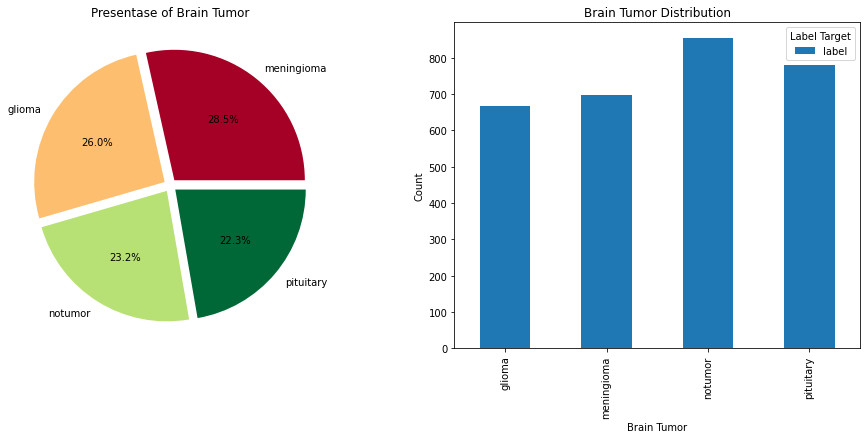

In [ ]:
#Distrubisi data label train set
fig, ax = plt.subplots(1,2,figsize=(16,6))
train_df['label'].value_counts().plot(
    kind='pie',
    labels=['meningioma', 'glioma', 'notumor','pituitary'],
    autopct='%1.1f%%',
    explode=[0.05,0.05,0.05,0.05],
    cmap='RdYlGn',
    ax=ax[0]
)
ax[0].set_title('Presentase of Brain Tumor')
ax[0].set_ylabel('')

#Barchart besaran setiap nilai pada kelas target
train_df.groupby('label').agg({'label':'count'}).plot(
    kind='bar',
    ax=ax[1]
)
ax[1].set_title('Brain Tumor Distribution')
ax[1].set_ylabel('Count')
ax[1].set_xlabel('Brain Tumor')
ax[1].legend(title='Label Target')

# Cek jumlah data train
print('train set: \n' + '='*50)
print(f'jumlah glioma= {glioma}')
print(f'jumlah meningloma= {meningioma}')
print(f'jumlah tidak tumor= {no_tumor}')
print(f'jumlah pituitary= {pituitary}')

Statement :
Pada data train, distribusi data pasien yang mengidap tumor glioma, tumor pituitary, tumor meningioma dan tidak tumor cenderung seimbang. Oleh karena itu tidak dilakukan balancing data. 

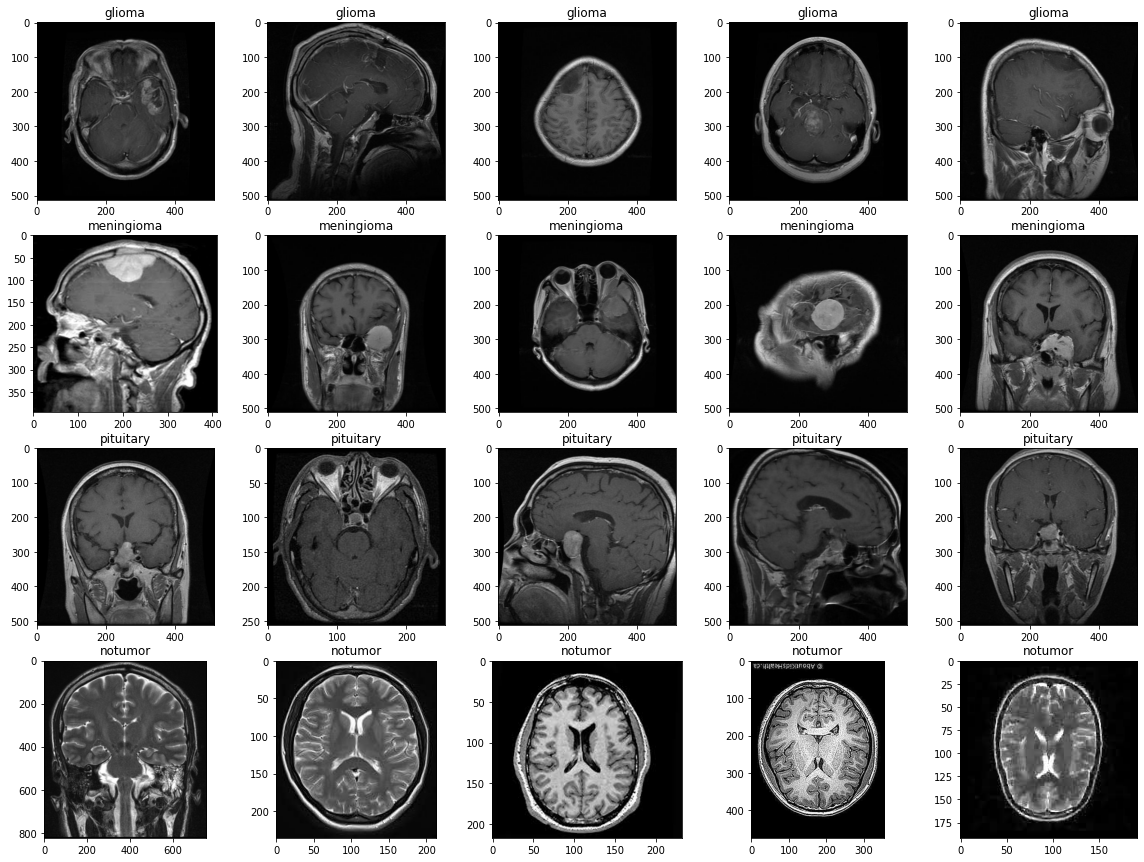

In [ ]:
# Get few samples for each class
glioma_samples = (train_df[train_df['label']=="glioma"]['images'].iloc[:5]).tolist()
meningioma_samples = (train_df[train_df['label']=='meningioma']['images'].iloc[:5]).tolist()
pituitary_samples = (train_df[train_df['label']=="pituitary"]['images'].iloc[:5]).tolist()
no_tumor_samples = (train_df[train_df['label']=='notumor']['images'].iloc[:5]).tolist()

# visualize sample images
def visualize_samples(samples):
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(20,15))
    for i, sample in enumerate(samples):
        img = cv2.imread(sample)
        ax[i//5, i%5].set_title(sample.split('/')[-2])
        ax[i//5, i%5].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

visualize_samples(glioma_samples + meningioma_samples + pituitary_samples + no_tumor_samples)

Pada hasil MRI beberapa pasien, terlihat bahwa pasien yang terdeteksi mengidap tumor otak cenderung memiliki sel-sel abnormal di sekitar otak. Sel-sel abnormal itu berwarna putih seperti yang ditunjukkan pada gambar pertama dari meningioma tumor.

# 5 - Data Preprocessing

Sebelum data dimasukkan kedalam model, data images tersebut harus dilakukan preprosessing terlebih dahulu. Preprosessing seperti melakukan rescale dan augmentasi untuk meningkatkan akurasi atau perfoma dari algoritma yang dibuat [4]

## 5.1 - Get Data Inference

In [ ]:
# create data inference
data_inf = train_df.sample(20, random_state=11)
data_inf

,images,label
903,/content/images/Training/meningioma/Tr-me_0060...,meningioma
601,/content/images/Training/pituitary/Tr-pi_0466.jpg,pituitary
2837,/content/images/Training/meningioma/Tr-me_1311...,meningioma
489,/content/images/Training/meningioma/Tr-me_1289...,meningioma
2407,/content/images/Training/meningioma/Tr-me_0460...,meningioma
2264,/content/images/Training/glioma/Tr-gl_0803.jpg,glioma
920,/content/images/Training/notumor/Tr-no_1541.jpg,notumor
1938,/content/images/Training/meningioma/Tr-meTr_00...,meningioma
164,/content/images/Training/notumor/Tr-no_0338.jpg,notumor
200,/content/images/Training/meningioma/Tr-me_0043...,meningioma


In [ ]:
# Remove data inference

data_train_val = train_df.drop(data_inf.index)
data_train_val.head()

,images,label
0,/content/images/Training/notumor/Tr-no_0219.jpg,notumor
1,/content/images/Training/notumor/Tr-no_0998.jpg,notumor
2,/content/images/Training/notumor/Tr-no_1051.jpg,notumor
3,/content/images/Training/notumor/Tr-no_0893.jpg,notumor
4,/content/images/Training/glioma/Tr-gl_0122.jpg,glioma


In [ ]:
# Reset Index untuk menghindari adanya error pada dataset

data_train_val.reset_index(drop= True, inplace = True)
data_inf.reset_index(drop = True, inplace= True)
data_inf.head()

,images,label
0,/content/images/Training/meningioma/Tr-me_0060...,meningioma
1,/content/images/Training/pituitary/Tr-pi_0466.jpg,pituitary
2,/content/images/Training/meningioma/Tr-me_1311...,meningioma
3,/content/images/Training/meningioma/Tr-me_1289...,meningioma
4,/content/images/Training/meningioma/Tr-me_0460...,meningioma


## 5.2 - Split data validation.

In [ ]:
# Split Data train dan validation
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=23, stratify = train_df['label'])
#Tampilkan shape setiap data
print('Size Train',train_df.shape)
print('Size Validation',val_df.shape)
print('Size Test', test_df.shape)
print('Size ', data_inf.shape)

Size Train (2400, 2)
Size Validation (600, 2)
Size Test (500, 2)
Size  (20, 2)


## Augmentasi Data

Seperti yang dijelaskan sebelumnya, dokter membutuhkan waktu sekitar 10 hingga 15 hari untuk  membuat keputusan tentang diagnosis tumor otak dan diagnosis tersebut memiliki resiko terjadinya kesalahan. Kita dapat menambah gambar dengan pola yang berbeda-beda. Hal ini bertujuan agar model dapat mempelajari data dengan baik sehingga performa model dapat meningkat.

Augmentasi data adalah teknik membuat gambar baru dari yang sudah ada. Untuk melakukan itu, kita dapat membuat beberapa perubahan kecil pada gambar, seperti menyesuaikan kecerahan gambar, atau memutar gambar, atau menggeser subjek gambar secara horizontal atau vertikal.
Hal ini dapat meningkatkan akurasi model dengan meningkatkan kemampuan model untuk mengenali pola gambar yang bervariasi.

Refensi Augmentasin data :
- https://towardsdatascience.com/image-data-augmentation-for-deep-learning-77a87fabd2bf
- (https://structilmy.com/blog/2021/01/18/image-classification-dengan-cnn-dan-tensorflow/)

Selanjutnya, menggunakan ImageDataGenarator untuk mengatur parameter augmentasi data. 

In [ ]:
# Lakukan augmentasi hanya pada data train
train_datagen = ImageDataGenerator(
    rescale=1./255, #normalisasi pixel
    rotation_range=10,#rotasi
    width_shift_range=0.2, #menggeser image (sumbu x)
    height_shift_range=0.2, # menggeser image (sumbu y)
    shear_range=0.2, #meregangkan image
    zoom_range=0.2,#memperbesar
    horizontal_flip=True) #pencerminan

# Lakukan resacle pada data test dan validasi
vaL_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


Data tidak dapa menerima inputan apabila ukuran width dan height gambar berbeda-beda, sehingga kita perlu menyamakan ukurannya dengan augmentasi data.

In [ ]:
# Definisikan panjang dan lebar
img_height= 280
img_width= 280
# Definisikan random number
SEED = 42
# Definisikan batch
BATCH = 64
#Definisikan color
color_mode='rgb'

Terapkan augmentasi pada dataframe

In [ ]:
# data train
ds_train = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width), #samakan size gambar input dan output
    class_mode='categorical',#categorical karena data labelnya multiclass
    batch_size=BATCH,
    color_mode=color_mode,
    shuffle=True,
    seed=SEED)

# data validation
ds_val = vaL_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='categorical',
    batch_size=BATCH,
    shuffle=False,
    seed=SEED)

#data test
ds_test = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='categorical',
    batch_size=BATCH,
    shuffle=False,
    seed=SEED)

Found 2400 validated image filenames belonging to 4 classes.
Found 600 validated image filenames belonging to 4 classes.
Found 500 validated image filenames belonging to 4 classes.


In [ ]:
#Mengecek label data
ds_train.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

- Untuk label glioma tumor diwakilkan dengan 0
- Untuk label meningioma tumor diwakilkan dengan 1
- Untuk label no tumor diwakilkan dengan 2
- Untuk label pituitary tumor diwakilkan dengan 3

# 6 - Model Definition

In [ ]:
# Definisikan input size
inputs= [img_height,img_width,3]

#arsitektur model sequential
model= Sequential()

#Layer Conv 1, bisa coba atur kernel_initializer dan activation
model.add(Conv2D(filters=16, kernel_size=3, activation='relu',padding='same',
                       input_shape=inputs))
# Flatten
model.add(Flatten())
model.add(Dense(units=16, activation='relu'))
#BatchNormalization
model.add(BatchNormalization())
# Hidden layer 1
model.add(Dense(32))
# Output Layer
model.add(Dense(units=4, activation='softmax'))# units :4, karena jumlah kelas dalam label ada 4, softmax karena data label multiclass

Model yang akan dibangun untuk pendeteksian tumor otak adalah model convolutional neural network. Untuk membangun model, definisikan model sequential api terlebih dahulu dan masukkan inputan sesuai dengan shape dari dataframe convolution layer.  Proses konvolusi memanfaatkan filter filter yang memiliki ukuran tinggi, lebar, dan tebal dan dan nilai dari filter inilah yang menjadi parameter yang akan di-update dalam proses learning. Filter yang digunakan adalah 16 dan ouput fitur maps akan menghasilkan ukuran 3x3. Layer berikutnya adalah layer flatten  yang digunakan untuk membentuk ulang feature maps menjadi sebuah vektor, outputnya nanti akan dimasukkan dalam hidden layer. Pada layer flatten ini digunakan 16 jumlah neuron. Selanjutkan dilakukan BatchNormalization yang merupakan proses untuk membuat neural network lebih cepat dan lebih stabil melalui penambahan lapisan ekstra dalam deep neural network. Layer selanjutnya adalah hidden layer yang merupakan full connected  yang akan menghitung skor kelas. Hiden layer yang digunakan dalam model default hanya 1 dengan neuron 32. Output layer berarti hasil klasifikasi dari kelas, activation yang digunakan adalah softmax karena dataset yang digunakan multiclass dan jumlah unit : 4 karena total class ada 4.

- Convolution & Pooling Layer:
https://medium.com/nodeflux/mengenal-convolutional-layer-dan-pooling-layer-3c6f5c393ab2
- BatchNormalization :
https://www.analyticsvidhya.com/blog/2021/03/introduction-to-batch-normalization/
-Flatten & Hidden Layer :
https://medium.com/@nadhifasofia/1-convolutional-neural-network-convolutional-neural-network-merupakan-salah-satu-metode-machine-28189e17335b

In [ ]:
#Compile
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics= ['accuracy'])

- Digunakan categorical crossentropy karena label hanya ada 4 kelas (multiclass)
- optimizer adam karena paling sering digunakan dan memiliki performa yang bagus
- metrics yang digunakan adalah accuracy untuk mengetahui performa model dalam memprediksi data dengan benar dari total kesulurahan data(data terprediksi benar +data terprediksi salah).

In [ ]:
#Summary dari model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 280, 280, 16)      448       
                                                                 
 flatten (Flatten)           (None, 1254400)           0         
                                                                 
 dense (Dense)               (None, 16)                20070416  
                                                                 
 batch_normalization (BatchN  (None, 16)               64        
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
 dense_2 (Dense)             (None, 4)                 132       
                                                        

**Model Summary**
Total parameter yang dapat di train pada model ini sebanyak 20,071,604. Namun, terdapat 32 params yang tidak di train sehingga total params yang ditrain menjadi 20,071,572.

# 7 - Model Training

Pada pemodelan digunakan early stopping dan model check point.
- Early stopping digunakan untuk menghentikan training jika val_loss tidak ada peningkatan
- Model check point digunakan untuk menyimpan model terbaik dengan monitoring dari nilai akurasi terbaik 

Reference :
- https://www.tensorflow.org/api_docs/python/tf/keras/callbacks

In [ ]:
#Definisikan callbacks
callbacks= [
            EarlyStopping(monitor= 'val_loss', mode='min', patience= 4, verbose=1),
            ModelCheckpoint('model_best.hdf5', monitor='accuracy', save_best_only= True)
]
 

In [ ]:
#Training model dengan 20 epoch
history= model.fit(ds_train, batch_size= BATCH, 
                           epochs= 20, validation_data= ds_val,
                           callbacks= callbacks)

Epoch 1/20
38/38 [==============================] - 52s 1s/step - loss: 1.2008 - accuracy: 0.4850 - val_loss: 4.1556 - val_accuracy: 0.2850
Epoch 2/20
38/38 [==============================] - 43s 1s/step - loss: 1.0488 - accuracy: 0.5825 - val_loss: 1.0191 - val_accuracy: 0.6650
Epoch 3/20
38/38 [==============================] - 44s 1s/step - loss: 0.9617 - accuracy: 0.6146 - val_loss: 0.9458 - val_accuracy: 0.6050
Epoch 4/20
38/38 [==============================] - 43s 1s/step - loss: 0.9239 - accuracy: 0.6342 - val_loss: 1.9042 - val_accuracy: 0.2767
Epoch 5/20
38/38 [==============================] - 43s 1s/step - loss: 0.8396 - accuracy: 0.6708 - val_loss: 1.9194 - val_accuracy: 0.4500
Epoch 6/20
38/38 [==============================] - 44s 1s/step - loss: 0.7834 - accuracy: 0.6938 - val_loss: 1.2219 - val_accuracy: 0.4800
Epoch 7/20
38/38 [==============================] - 42s 1s/step - loss: 0.7750 - accuracy: 0.6862 - val_loss: 1.0893 - val_accuracy: 0.5517
Epoch 7: early stopp

# Evaluasi

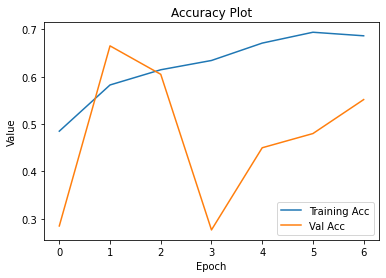

In [ ]:
plt.plot(history.history['accuracy'], label='Training Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Plot')
plt.ylabel('Value') 
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

Statement :

Berdasarkan grafik diatas, nilai accuracy pada train set cenderung meningkat. Namun, nilai accuracy pada validation set sangat tidak stabil, terlihat beberapa fenomena exploding. Karena nilai accuracy pada data train dan validation set dibawah 0.6, maka dikatakan bahwa model default cendrung underfiting.

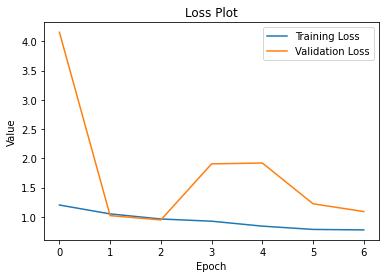

In [ ]:
#loss train & validation
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

Statement :
Sama halnya dengan nilai accuracy, nilai loss data validation cendrung tidak stabil. Meskipun nilai loss train set cenderung menurun. Namun nilai loss train set dan validation set  tinggi yang menunjukkan tingginya error model dalam memprediksi data.

# 8 - Model Evaluation

Selanjutnya dilakukan evaluasi pada date test untuk melihat performa model pada da test.

In [ ]:
results = model.evaluate(ds_test, verbose=0)
print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 1.17997
Test Accuracy: 50.80%


Ketika model default diterapkan pada data test, nilai loss nya sangat tinggi dan accuracy nya tergolong rendah.

In [ ]:
#Predict data test
y_pred = model.predict(ds_test)
y_pred

8/8 [==============================] - 1s 183ms/step


array([[0.5128845 , 0.27121958, 0.01590534, 0.19999063],
       [0.23383997, 0.34548163, 0.17886437, 0.24181402],
       [0.7699733 , 0.17738436, 0.00397129, 0.04867107],
       ...,
       [0.04342177, 0.16922353, 0.41775367, 0.369601  ],
       [0.75805587, 0.05360134, 0.00181521, 0.18652755],
       [0.04922051, 0.19570382, 0.31809136, 0.43698433]], dtype=float32)

In [ ]:
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([0, 1, 0, 0, 2, 0, 1, 2, 3, 1, 3, 0, 3, 0, 3, 1, 0, 0, 3, 0, 3, 1,
       2, 0, 3, 0, 0, 0, 3, 1, 0, 0, 2, 2, 2, 0, 0, 3, 2, 0, 0, 1, 3, 2,
       0, 0, 0, 3, 3, 0, 0, 0, 3, 0, 0, 0, 3, 0, 3, 0, 3, 0, 3, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 2, 3, 3, 1, 3, 3, 0, 3,
       1, 0, 1, 0, 0, 0, 3, 2, 0, 0, 0, 0, 1, 2, 0, 0, 0, 2, 1, 1, 1, 0,
       3, 3, 1, 0, 0, 0, 0, 0, 0, 1, 0, 3, 0, 0, 0, 1, 0, 0, 1, 0, 0, 3,
       0, 0, 0, 0, 1, 3, 3, 0, 1, 2, 0, 0, 3, 1, 3, 3, 3, 0, 0, 0, 0, 0,
       0, 3, 0, 0, 1, 3, 0, 3, 3, 0, 3, 0, 3, 0, 1, 3, 0, 0, 3, 1, 0, 3,
       0, 2, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 3, 0, 3, 0, 0, 3, 3, 3, 3,
       3, 0, 3, 0, 3, 3, 0, 2, 3, 2, 3, 0, 0, 0, 3, 3, 3, 0, 0, 0, 3, 3,
       0, 3, 1, 2, 0, 0, 3, 0, 1, 3, 0, 2, 0, 3, 0, 0, 3, 0, 2, 2, 0, 0,
       0, 0, 3, 0, 3, 3, 0, 3, 2, 0, 3, 3, 3, 0, 0, 0, 0, 0, 3, 3, 3, 2,
       0, 1, 0, 0, 0, 0, 3, 2, 3, 0, 1, 0, 3, 2, 0, 0, 0, 3, 0, 1, 0, 3,
       0, 1, 0, 0, 0, 0, 0, 3, 0, 2, 0, 0, 3, 3, 3,

In [ ]:
#Classification Report default model

cm = confusion_matrix(ds_test.labels, y_pred)
print(cm)
print('classification report')
print( classification_report(ds_test.labels, y_pred))

[[111   0   0   3]
 [ 74  12   4  19]
 [ 25  42  44  46]
 [ 33   0   0  87]]
classification report
              precision    recall  f1-score   support

           0       0.46      0.97      0.62       114
           1       0.22      0.11      0.15       109
           2       0.92      0.28      0.43       157
           3       0.56      0.72      0.63       120

    accuracy                           0.51       500
   macro avg       0.54      0.52      0.46       500
weighted avg       0.58      0.51      0.46       500



Statement :
Setelah diterapkan pada test, kita dapat tahu bahwa model hanya baik dalam meminimalisir kesalahan prediksi data tumor glioma dengan recall score (0.97) dan pituitary (0.72), namun tidak baik dalam meminimalisir data tumor meningioma(0.11) dan no tumor (0.28). Karena performa model tumpang tindih, hanya baik dalam memprediksi class tertentu sehingga didapatkan f1 score 0.51 yang artinya performa model pada data test tidak baik.  

In [ ]:
#Fungsi untuk membuat confussion matrix

def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=False):
    """
    arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
    """
     
    if cmap is None:
        cmap = plt.get_cmap('Oranges')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylim(len(target_names)-0.5, -0.5)
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.savefig(title + '.jpg', dpi=500, bbox_inches = 'tight')
    plt.show()

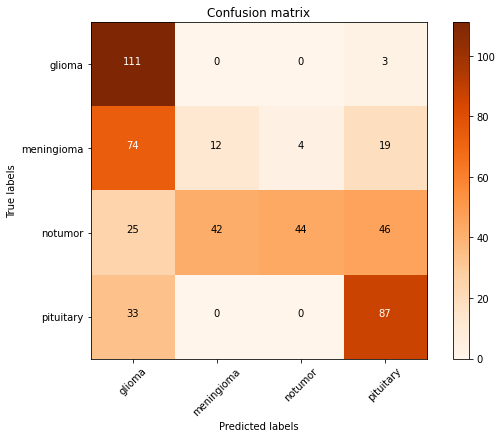

In [ ]:
# a tuple for all the class names
target_names = ('glioma', 'meningioma', 'notumor', 'pituitary' )
plot_confusion_matrix(cm, target_names)

Dari confussion matrix, didapatkan bahwa:
- Terdapat 111 data tumor glioma diprediksi dengan benar, sedangkan 3 data lainnya salah prediksi.
- Hanya terdapat 12 data meningioma dari 109 total data dipredikai dengan benar, sedangkan 97 data lainnya diprediksi tidak benar.
- Dari 157 data tidak tumor, hanya 44 data yang terperdiksi dengan benar dan 113 lainnya terprediksi salah
- 87 data pituitary terpediksi dengan benar, namun sebanyak 33 data terprediksi tidak benar.

Dari jumlah data yang terprediksi dengan benar, kembali kita lihat bahwa model ini hanya bekerja dengan baik pada data glioma dan pituitary.

In [ ]:
ds_train.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

# 9 - Model Improvement

Pada model default nilai accuracy nya sangat kecil, sehingga pada model improvement yang pertama akan ditambahkan beberapa layer, 1 layer convolution dan 2 hidden layer. Selain itu, jumlah neuron pada tiap layer akan ditingkatkan. 

- Convolution layer, pada layer convolution 1 digunakan filter 16 dengan kernel_size dan penambahan padding. Padding digunakan dengan tujuan untuk memanipulasi dimensi output dari conv. layer (Feature Map).Kemudian ditambahkan pooling yaitu AveragePooling pool_size 2 dan strides 2. Pooling digunakan untuk mengurangi jumlah dimensi dimana prinsip kerjanya mirip seperti PCA pada machine learning yang mencari fiture paling penting. AveragePolling mengambil nilai rata" dari screaning yang dilakukan. Stride adalah parameter yang menentukan berapa jumlah pergeseran filter. Kemudian pada convolution layer 2, jumlah filter ditingkatkan menjadi 32, sedangkan parameter lainnya tetap sama.

- Batch Normalization, tidak ada perubahan parameter pada layer ini.

- Flatten Layer, pada model improve 1, jumlah neuron pada flatten layer ditingkatkan 2 kali lipat dari neuron pada model default.

- Hidden Layer, pada model ini digunakan 3 hidden layer dengan neuron 32,64, 128 kemudian ditambahkan dropout dimana beberapa neuron tidak akan digunakan pada proses training. Dropout ini mencegah terjadinya overfitting dan juga mempercepat proses learning. Dropout di set 0.2 pada setiap layer artinya setiap layer tidak akan mentraining 20% neuron pada setiap layer. 

-Output layer, menggunakan activation softmax dengan 4 units. 

Pooling:
- https://medium.com/@samuelsena/pengenalan-deep-learning-part-7-convolutional-neural-network-cnn-b003b477dc94
Dropout:
- https://medium.com/@16611110/apa-itu-convolutional-neural-network-836f70b193a4

In [ ]:
#arsitektur model sequential
model_imp1= Sequential()

#Layer Conv 1, bisa coba atur kernel_initializer dan activation
model_imp1.add(Conv2D(filters=16, kernel_size=3, activation='relu',padding='same',
                       input_shape=inputs))
model_imp1.add(AveragePooling2D(pool_size= 2, strides=2))
#Layer Conv 2
model_imp1.add(Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'))
model_imp1.add(AveragePooling2D(pool_size= 2, strides=2))
# Flatten
model_imp1.add(Flatten())
model_imp1.add(Dense(units=32, activation='relu'))
#BatchNormalization
model_imp1.add(BatchNormalization())
#Hidden layer 1
model_imp1.add(Dense(32, activation= 'relu'))
model_imp1.add(Dropout(rate=0.2))
#Hidden layer 2
model_imp1.add(Dense(64, activation= 'relu'))
model_imp1.add(Dropout(rate=0.2))
#Hidden layer 3
model_imp1.add(Dense(128, activation= 'relu'))
model_imp1.add(Dropout(rate=0.2))
#Output layer
model_imp1.add(Dense(units=4,activation='softmax'))

In [ ]:
#Summary dari model
model_imp1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 280, 280, 16)      448       
                                                                 
 average_pooling2d (AverageP  (None, 140, 140, 16)     0         
 ooling2D)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 140, 140, 32)      4640      
                                                                 
 average_pooling2d_1 (Averag  (None, 70, 70, 32)       0         
 ePooling2D)                                                     
                                                                 
 flatten_1 (Flatten)         (None, 156800)            0         
                                                                 
 dense_3 (Dense)             (None, 32)               

In [ ]:
#Compile
model_imp1.compile(optimizer='Adam', loss='categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
# training model dengan 30 epoch
history_imp1 = model_imp1.fit(ds_train, 
                    epochs=30, 
                    validation_data=(ds_val),
                    batch_size= BATCH,
                    callbacks= callbacks,
                    verbose=1)

Epoch 1/30
38/38 [==============================] - 45s 1s/step - loss: 1.2065 - accuracy: 0.4408 - val_loss: 2.3592 - val_accuracy: 0.2850
Epoch 2/30
38/38 [==============================] - 43s 1s/step - loss: 0.9714 - accuracy: 0.5900 - val_loss: 0.9780 - val_accuracy: 0.5733
Epoch 3/30
38/38 [==============================] - 42s 1s/step - loss: 0.9008 - accuracy: 0.6171 - val_loss: 1.4778 - val_accuracy: 0.4533
Epoch 4/30
38/38 [==============================] - 42s 1s/step - loss: 0.8709 - accuracy: 0.6392 - val_loss: 0.9112 - val_accuracy: 0.6117
Epoch 5/30
38/38 [==============================] - 43s 1s/step - loss: 0.8191 - accuracy: 0.6658 - val_loss: 1.5381 - val_accuracy: 0.4517
Epoch 6/30
38/38 [==============================] - 42s 1s/step - loss: 0.7905 - accuracy: 0.6833 - val_loss: 0.9078 - val_accuracy: 0.6083
Epoch 7/30
38/38 [==============================] - 42s 1s/step - loss: 0.7578 - accuracy: 0.6983 - val_loss: 0.6255 - val_accuracy: 0.7617
Epoch 8/30
38/38 [==

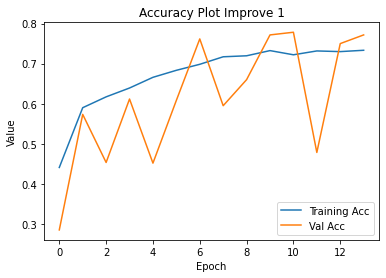

In [ ]:
#Accuracy train &validation
plt.plot(history_imp1.history['accuracy'], label='Training Acc')
plt.plot(history_imp1.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Plot Improve 1')
plt.ylabel('Value') 
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

Statement :
Grafik accuracy model improve 1 menunjukkan hasil yang lebih baik dengan peningkatan nilai accuracy pada train. Namun, data validasi tetap menunjukkan ketidakstabilan nilai accuracy, terdapat beberapa fenomena exploding. Meskipun accuracynya lebih meningkat dibanding model default, model improve 1 ini masih tergolong underfit.

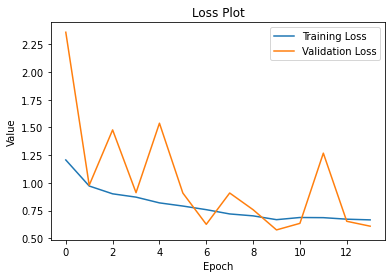

In [ ]:
#loss train & validation
plt.plot(history_imp1.history['loss'], label='Training Loss')
plt.plot(history_imp1.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

Statement:
Loss train set juga menunjukkan hasil yang lebih baik pada model improve 1 ini. Tapi data validasinya tetap tidak stabil.

In [ ]:
#Evaluasi data test
results1 = model_imp1.evaluate(ds_test, verbose=0)
print("    Test Loss: {:.5f}".format(results1[0]))
print("Test Accuracy: {:.2f}%".format(results1[1] * 100))

    Test Loss: 0.70760
Test Accuracy: 72.20%


Setelah diterapkan pada model test, dapat diketahui kesalahan prediksi pada model lebih kecil dibanding model default namun nilainya masih tinggi. Accuracy model juga meningkat 20 persen.

In [ ]:
#Predict data test
y_pred1 = model_imp1.predict(ds_test)
y_pred1

8/8 [==============================] - 2s 179ms/step


array([[1.2598197e-01, 5.3261632e-01, 8.6656958e-03, 3.3273599e-01],
       [1.6629600e-03, 1.0764721e-01, 7.9309517e-01, 9.7594708e-02],
       [3.9948216e-01, 5.8291733e-01, 1.2091881e-03, 1.6391333e-02],
       ...,
       [1.0448227e-05, 1.8896766e-02, 9.8056650e-01, 5.2628532e-04],
       [9.1821676e-01, 2.4962856e-02, 3.7413412e-03, 5.3078946e-02],
       [4.7489324e-05, 6.8422571e-02, 8.7992120e-01, 5.1608764e-02]],
      dtype=float32)

In [ ]:
y_pred1 = np.argmax(y_pred1, axis=1)
y_pred1

array([1, 2, 1, 0, 2, 0, 2, 2, 2, 2, 3, 3, 3, 1, 2, 2, 0, 0, 3, 0, 3, 2,
       2, 0, 2, 0, 3, 1, 3, 2, 1, 1, 2, 2, 2, 1, 2, 3, 2, 2, 3, 2, 3, 2,
       3, 1, 1, 2, 3, 3, 1, 0, 3, 3, 1, 1, 3, 3, 2, 0, 3, 3, 3, 0, 1, 0,
       1, 1, 2, 0, 0, 2, 2, 2, 2, 2, 0, 0, 3, 0, 2, 3, 2, 2, 3, 3, 0, 3,
       2, 3, 2, 3, 3, 3, 2, 2, 3, 3, 3, 1, 2, 2, 0, 3, 0, 2, 2, 2, 2, 3,
       3, 3, 2, 2, 3, 3, 3, 0, 3, 2, 1, 3, 3, 3, 2, 2, 2, 2, 2, 0, 2, 3,
       1, 0, 0, 1, 2, 3, 3, 3, 2, 2, 3, 2, 3, 2, 3, 2, 3, 3, 3, 1, 1, 3,
       0, 3, 2, 2, 2, 2, 1, 3, 3, 3, 2, 3, 2, 2, 2, 2, 1, 3, 2, 2, 0, 3,
       0, 2, 3, 3, 1, 1, 2, 2, 0, 2, 2, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 0, 3, 1, 3, 3, 1, 2, 3, 2, 3, 0, 3, 3, 2, 3, 2, 2, 3, 0, 3, 3,
       2, 3, 2, 2, 3, 1, 3, 1, 2, 2, 0, 2, 1, 3, 0, 3, 3, 0, 2, 2, 0, 3,
       3, 1, 3, 0, 3, 3, 0, 2, 2, 3, 3, 3, 3, 0, 3, 0, 1, 0, 2, 2, 3, 2,
       0, 2, 2, 3, 1, 3, 3, 2, 3, 3, 2, 3, 3, 2, 1, 0, 3, 3, 1, 2, 0, 3,
       0, 2, 3, 1, 2, 3, 3, 3, 3, 2, 0, 0, 3, 2, 3,

In [ ]:
#Confusion matrix
cm1 = confusion_matrix(ds_test.labels, y_pred1)
print(cm1)
print('classification report')
print( classification_report(ds_test.labels, y_pred1))

[[ 62  24   1  27]
 [  8  33  26  42]
 [  1   0 146  10]
 [  0   0   0 120]]
classification report
              precision    recall  f1-score   support

           0       0.87      0.54      0.67       114
           1       0.58      0.30      0.40       109
           2       0.84      0.93      0.88       157
           3       0.60      1.00      0.75       120

    accuracy                           0.72       500
   macro avg       0.72      0.69      0.68       500
weighted avg       0.74      0.72      0.70       500



Dari classification report dapat diketahui bahwa model ini sangat baik dalam meminimalisir kesalahan data pituitary tumor dan data no tumor dengan recall masing" 1.00 dan 0.97. Namun masih tidak baik dalam meminimalisir kesalahan prediksi data glioma tumor dan meningioma tumor dengan recall score 0.54 dan 0.30.

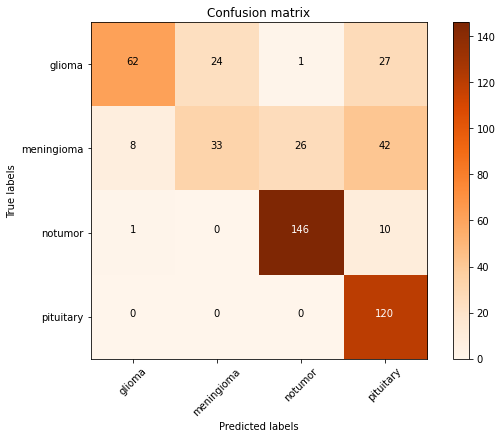

In [ ]:
# a tuple for all the class names
plot_confusion_matrix(cm1, target_names)

Confussion Matrix menunjukkan:
- Model dapat memeprediksi 62 data  glioma tumor dengan benar dan salah memprediksi 52 data.
- Hanya 33 data meningioma tumor yang dapat di prediksi dengan benar dan 76 data terpediksi salah.
-  Terdapat 146 data no tumor terprediksi dengan benar dan 11 data terprediksi salah.
- Mosel dapat memprediksi semua data pituitary tumor dengan benar

**Improve 2**

In [ ]:
from keras.optimizers import SGD

Pada model improve 1, terdapat beberapa fenomene exploding, pada model 2 kita akan mencobah menghandle fenomena exploding dengan gradien clipping, sehingga perlu mengganti optimizer menadi SGD.

In [ ]:
#arsitektur model sequential
model_imp2= Sequential()

#Layer Conv 1, bisa coba atur kernel_initializer dan activation
model_imp2.add(Conv2D(filters=16, kernel_size=3, activation='relu',padding='same',
                       input_shape=inputs))
model_imp2.add(AveragePooling2D(pool_size= 2, strides=2))
#Layer Conv 2
model_imp2.add(Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'))
model_imp2.add(AveragePooling2D(pool_size= 2, strides=2))
#Layer Conv 3
model_imp2.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model_imp2.add(AveragePooling2D(pool_size= 2, strides=2))
# Flatten
model_imp2.add(Flatten())
model_imp2.add(Dense(units=32, activation='relu'))
#Hidden layer 1
model_imp2.add(Dense(128, activation= 'relu'))
model_imp2.add(Dropout(rate=0.2))
#Hidden layer 2
model_imp2.add(Dense(64, activation= 'relu'))
model_imp2.add(Dropout(rate=0.2))
#Hidden layer 3
model_imp2.add(Dense(32, activation= 'relu'))
model_imp2.add(Dropout(rate=0.2))
#Output layer
model_imp2.add(Dense(units=4,activation='softmax'))

In [ ]:

# configure sgd with gradient norm clipping
opt = SGD(lr=0.01, momentum=0.9, clipvalue=0.5)

In [ ]:
#Compile
model_imp2.compile(optimizer=opt, loss='categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
# training model dengan 30 epoch
history_imp2 = model_imp2.fit(ds_train, 
                    epochs=30, 
                    validation_data=(ds_val),
                    batch_size= BATCH,
                    callbacks= callbacks,
                    verbose=1)

Epoch 1/30
38/38 [==============================] - 45s 1s/step - loss: 1.3553 - accuracy: 0.2942 - val_loss: 1.2941 - val_accuracy: 0.3317
Epoch 2/30
38/38 [==============================] - 42s 1s/step - loss: 1.2564 - accuracy: 0.4004 - val_loss: 1.1096 - val_accuracy: 0.6350
Epoch 3/30
38/38 [==============================] - 42s 1s/step - loss: 1.1833 - accuracy: 0.5017 - val_loss: 1.2692 - val_accuracy: 0.4833
Epoch 4/30
38/38 [==============================] - 43s 1s/step - loss: 1.1532 - accuracy: 0.5233 - val_loss: 1.2738 - val_accuracy: 0.3817
Epoch 5/30
38/38 [==============================] - 42s 1s/step - loss: 1.1385 - accuracy: 0.5150 - val_loss: 0.9053 - val_accuracy: 0.6650
Epoch 6/30
38/38 [==============================] - 42s 1s/step - loss: 1.0555 - accuracy: 0.5763 - val_loss: 0.8472 - val_accuracy: 0.6767
Epoch 7/30
38/38 [==============================] - 43s 1s/step - loss: 1.0266 - accuracy: 0.5750 - val_loss: 0.8579 - val_accuracy: 0.7033
Epoch 8/30
38/38 [==

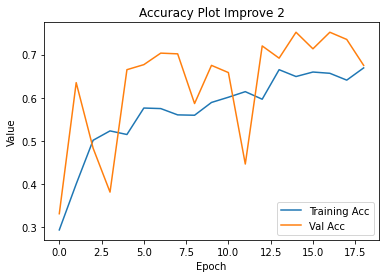

In [ ]:
#Accuracy train &validation
plt.plot(history_imp2.history['accuracy'], label='Training Acc')
plt.plot(history_imp2.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Plot Improve 2')
plt.ylabel('Value') 
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

Setelah mengubah optimizer, ternyata fenomena exploding masih ada dan terlihat nilai accuracy train set cenderung menurun dari model sebelumnya. Karena nilai accuracy train set dan validation set cenderung kecil sehingga dikatakan model improve 2 underfit.

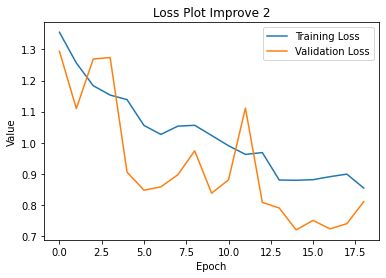

In [ ]:
#loss train & validation
plt.plot(history_imp2.history['loss'], label='Training Loss')
plt.plot(history_imp2.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot Improve 2')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

Loss dari training cenderung menurun. Namun nilai loos pada validation set tetap tidak stabil dan didapatkan beberapa fenomena exploding. 

In [ ]:
# Loss Accuracy 
results2 = model_imp2.evaluate(ds_test, verbose=0)
print("    Test Loss: {:.5f}".format(results2[0]))
print("Test Accuracy: {:.2f}%".format(results2[1] * 100))

    Test Loss: 0.70760
Test Accuracy: 72.20%


In [ ]:
#Predict data test
y_pred2 = model_imp2.predict(ds_test)
y_pred2

8/8 [==============================] - 2s 181ms/step


array([[4.4199813e-02, 1.4063978e-01, 6.2017806e-02, 7.5314265e-01],
       [2.9627880e-02, 5.3019023e-01, 4.2041004e-01, 1.9771839e-02],
       [1.1332466e-01, 2.1662265e-01, 4.1633643e-02, 6.2841910e-01],
       ...,
       [1.1462606e-03, 1.2901473e-01, 8.4162563e-01, 2.8213371e-02],
       [7.3601627e-01, 1.6577372e-01, 5.2933078e-02, 4.5276891e-02],
       [9.4882926e-05, 7.6918982e-02, 9.1486782e-01, 8.1182374e-03]],
      dtype=float32)

In [ ]:
y_pred2 = np.argmax(y_pred2, axis=1)
y_pred2

array([3, 1, 3, 0, 2, 0, 2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 0, 0, 3, 1, 3, 2,
       2, 1, 2, 0, 3, 1, 2, 2, 1, 1, 2, 2, 2, 1, 0, 3, 2, 2, 3, 2, 3, 2,
       3, 3, 1, 2, 3, 3, 1, 0, 2, 3, 3, 1, 3, 1, 2, 0, 3, 3, 3, 1, 1, 1,
       3, 3, 1, 3, 0, 2, 2, 2, 2, 2, 0, 1, 1, 0, 2, 2, 2, 2, 3, 3, 0, 3,
       2, 1, 2, 1, 1, 3, 0, 2, 3, 3, 3, 1, 2, 2, 0, 1, 0, 2, 2, 2, 2, 1,
       2, 3, 1, 3, 1, 3, 1, 0, 3, 2, 1, 3, 3, 3, 1, 2, 2, 2, 2, 0, 2, 3,
       1, 0, 0, 3, 2, 3, 3, 1, 2, 2, 2, 1, 3, 2, 3, 2, 3, 1, 2, 3, 3, 3,
       3, 3, 1, 0, 2, 3, 1, 3, 3, 3, 2, 3, 2, 1, 2, 2, 1, 3, 3, 2, 0, 3,
       0, 2, 1, 3, 3, 1, 2, 1, 1, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 1, 3, 3, 3, 2, 3, 2, 3, 0, 3, 0, 2, 3, 2, 2, 1, 3, 3, 3,
       2, 3, 2, 2, 3, 3, 3, 3, 2, 2, 0, 2, 1, 2, 1, 2, 3, 1, 2, 2, 0, 3,
       3, 3, 3, 1, 3, 3, 1, 1, 2, 3, 3, 3, 3, 1, 1, 1, 1, 0, 2, 2, 3, 2,
       0, 2, 1, 1, 2, 3, 3, 2, 3, 3, 2, 3, 3, 2, 1, 3, 3, 3, 3, 2, 1, 3,
       0, 2, 3, 3, 1, 0, 3, 3, 3, 2, 0, 0, 3, 0, 3,

In [ ]:
#Confusion matrix
cm2 = confusion_matrix(ds_test.labels, y_pred2)
print(cm2)
print('classification report')
print( classification_report(ds_test.labels, y_pred2))

[[ 41  38   1  34]
 [  3  35  29  42]
 [  5  13 125  14]
 [  0   4   1 115]]
classification report
              precision    recall  f1-score   support

           0       0.84      0.36      0.50       114
           1       0.39      0.32      0.35       109
           2       0.80      0.80      0.80       157
           3       0.56      0.96      0.71       120

    accuracy                           0.63       500
   macro avg       0.65      0.61      0.59       500
weighted avg       0.66      0.63      0.61       500



Dari classification report dapat diketahui bahwa model ini sangat baik dalam meminimalisir kesalahan data pituitary tumor dan data no tumor dengan recall masing" 0.96 dan 0.80. Namun masih tidak baik dalam meminimalisir kesalahan prediksi data glioma tumor dan meningioma tumor dengan recall score 0.36 dan 0.32.

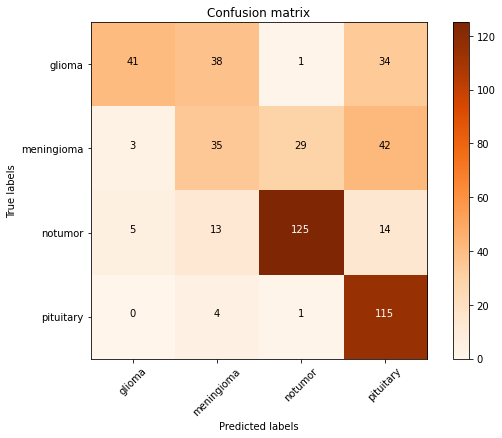

In [ ]:
# a tuple for all the class names
plot_confusion_matrix(cm2, target_names)

Confussion Matrix menunjukkan:

- Model dapat memeprediksi 41 data glioma tumor dengan benar dan salah memprediksi 52 data.
- Hanya 33 data meningioma tumor yang dapat di prediksi dengan benar dan 76 data terpediksi salah.
- Terdapat 146 data no tumor terprediksi dengan benar dan 11 data terprediksi salah.
- Model dapat memprediksi semua data pituitary tumor dengan benar

# 10 - Model Inference

Berdasarkan evaluasi model, model terbaik adalah model improvement 1 dengan accuracy sekitar 72%. Model tersebut telah disimpan karena kita telah mengatur model check point, sehingga hanya perlu load model terbaik.

In [ ]:
# load best model
model_cnn = load_model('model_best.hdf5')
model_cnn

In [ ]:
#Display data inference
data_inf

,images,label
0,/content/images/Training/meningioma/Tr-me_0060...,meningioma
1,/content/images/Training/pituitary/Tr-pi_0466.jpg,pituitary
2,/content/images/Training/meningioma/Tr-me_1311...,meningioma
3,/content/images/Training/meningioma/Tr-me_1289...,meningioma
4,/content/images/Training/meningioma/Tr-me_0460...,meningioma
5,/content/images/Training/glioma/Tr-gl_0803.jpg,glioma
6,/content/images/Training/notumor/Tr-no_1541.jpg,notumor
7,/content/images/Training/meningioma/Tr-meTr_00...,meningioma
8,/content/images/Training/notumor/Tr-no_0338.jpg,notumor
9,/content/images/Training/meningioma/Tr-me_0043...,meningioma


In [ ]:

# lakukan rescaling
inf_datagen= ImageDataGenerator(rescale= 1./255)

# masukkan dalam dataframe inference
ds_inf= inf_datagen.flow_from_dataframe(
    dataframe= data_inf,
    x_col= 'images',
    y_col= 'label',
    target_size= (img_height, img_width),
    class_mode= 'categorical',
    batch_size= BATCH,
    shuffle= False,
    seed= SEED)
     

Found 20 validated image filenames belonging to 4 classes.


Lakukan prediksi untuk data inference

In [ ]:
# lakukan prediksi
y_pred_inf = model_cnn.predict(ds_inf)
y_pred_inf = np.argmax(y_pred_inf, axis=1)

# membuat hasil prediksi menjadi dataframe
y_pred_inf_df = pd.DataFrame(y_pred_inf, columns=['label Prediction'])
# konversi value
y_pred_inf_df['label Prediction'].replace(to_replace=0, value='glioma', inplace=True)
y_pred_inf_df['label Prediction'].replace(to_replace=1,  value='meningioma', inplace=True)
y_pred_inf_df['label Prediction'].replace(to_replace=2, value='notumor', inplace=True)
y_pred_inf_df['label Prediction'].replace(to_replace=3,  value='pituitary', inplace=True)
 

1/1 [==============================] - 0s 155ms/step


In [ ]:
# Gabungkan data Inference dengan kolom prekdiksi
data_inf_predict = pd.concat([data_inf, y_pred_inf_df], axis=1)
data_inf_predict

,images,label,label Prediction
0,/content/images/Training/meningioma/Tr-me_0060...,meningioma,pituitary
1,/content/images/Training/pituitary/Tr-pi_0466.jpg,pituitary,pituitary
2,/content/images/Training/meningioma/Tr-me_1311...,meningioma,pituitary
3,/content/images/Training/meningioma/Tr-me_1289...,meningioma,meningioma
4,/content/images/Training/meningioma/Tr-me_0460...,meningioma,pituitary
5,/content/images/Training/glioma/Tr-gl_0803.jpg,glioma,glioma
6,/content/images/Training/notumor/Tr-no_1541.jpg,notumor,pituitary
7,/content/images/Training/meningioma/Tr-meTr_00...,meningioma,pituitary
8,/content/images/Training/notumor/Tr-no_0338.jpg,notumor,pituitary
9,/content/images/Training/meningioma/Tr-me_0043...,meningioma,meningioma


In [ ]:
# hasil sebenarnya
data_inf_predict['label'].value_counts()

meningioma    8
notumor       5
pituitary     4
glioma        3
Name: label, dtype: int64

In [ ]:
# hasil prediksi
data_inf_predict['label Prediction'].value_counts()

pituitary     11
meningioma     3
glioma         3
notumor        3
Name: label Prediction, dtype: int64

In [ ]:
#Confusion matrix
cm_inf = confusion_matrix(ds_inf.labels, y_pred_inf)
print(cm_inf)
print('classification report')
print( classification_report(ds_inf.labels, y_pred_inf))

[[3 0 0 0]
 [0 3 0 5]
 [0 0 3 2]
 [0 0 0 4]]
classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      0.38      0.55         8
           2       1.00      0.60      0.75         5
           3       0.36      1.00      0.53         4

    accuracy                           0.65        20
   macro avg       0.84      0.74      0.71        20
weighted avg       0.87      0.65      0.66        20



Setelah menerapkan model improvement 1 pada data inference didapatkan bahwa model mampu memprediksi data glioma tumor dan meningioma tumor dengan benar, namun masih kurang dalam memprediksi data no tumor dan buruk dalam memprediksi data meningioma tumor.


# 11 - Kesimpulan

- Pada data train, distribusi data pasien yang mengidap tumor glioma, tumor pituitary, tumor meningioma dan tidak tumor cenderung seimbang. 
- Best Model adalah Model improvement 1 yang telah dilakukan penambahan layer, peningkatan jumlah neuron dan dropout. Performa model improvement 1 meningkat 20% dari performa model default. Model ini berhasil memprediksi dengan baik data tumor glioma dan pituitary tumor. Namun, belum berhasil memprediksi data meningioma tumor dan meningioma tumor dengan baik.
- MRI memiliki color image gray yang dapat membuat model sulit mengenali pola tumor. Perorma model dalam mendeteksi data tumor dapat ditingkat dengan mereset paremeter dari augmentasi, kita dapat mengatur kecerahan dll. Selain itu kita dapat mengganti kernel_size yang mempu mengenali pola dengan baik.